# Machine Learning Engineer Nanodegree
## Model Evaluation & Validation
## Project: Predicting Boston Housing Prices

Welcome to the first project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started
In this project, you will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home — in particular, its monetary value. This model would prove to be invaluable for someone like a real estate agent who could make use of such information on a daily basis.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

Run the code cell below to load the Boston housing dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [150]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.cross_validation import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print "Boston housing dataset has {} data points with {} variables each.".format(*data.shape)

Boston housing dataset has 489 data points with 4 variables each.


## Data Exploration
In this first section of this project, you will make a cursory investigation about the Boston housing data and provide your observations. Familiarizing yourself with the data through an explorative process is a fundamental practice to help you better understand and justify your results.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we will need to separate the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Implementation: Calculate Statistics
For your very first coding implementation, you will calculate descriptive statistics about the Boston housing prices. Since `numpy` has already been imported for you, use this library to perform the necessary calculations. These statistics will be extremely important later on to analyze various prediction results from the constructed model.

In the code cell below, you will need to implement the following:
- Calculate the minimum, maximum, mean, median, and standard deviation of `'MEDV'`, which is stored in `prices`.
  - Store each calculation in their respective variable.

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


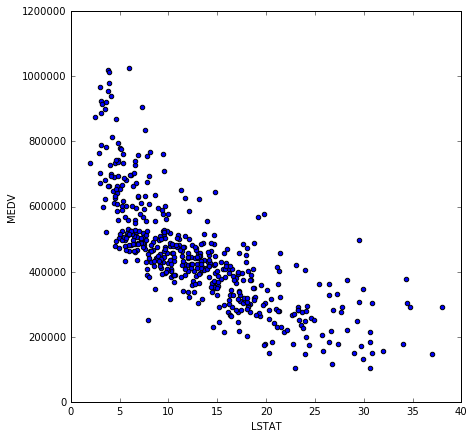

In [151]:
minimum_price = np.min(data['MEDV'])
maximum_price = np.max(data['MEDV'])
mean_price = np.mean(data['MEDV'])
median_price = np.median(data['MEDV'])
std_price = np.std(data['MEDV'])

# Show the calculated statistics
print "Statistics for Boston housing dataset:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.scatter(features['LSTAT'], prices)

### Question 1 - Feature Observation
As a reminder, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

_Using your intuition, for each of the three features above, do you think that an increase in the value of that feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`? Justify your answer for each._  
**Hint:** Would you expect a home that has an `'RM'` value of 6 be worth more or less than a home that has an `'RM'` value of 7?

**Answer: **

*For RM, the larger the value, the __higher__ the price likely is. The amount of rooms is one of the main ways in which the real estate market evaluate a house.*


*For LSTAT, the larger the value, the __lower__ the price likely is. A large percentage indicates a relatively poorer district, which is another factor that usually depress the price of residences (how much "living in district X" is worth).*

*For PTRATIO, on the other hand, the larger the value, the __lower__ the price likely will drop. A high students-to-teacher ratio usually indicates worse schools, where kids don't get as many chance to interact with their mentors and to learn more interactively.*


----

## Developing a Model
In this second section of the project, you will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
It is difficult to measure the quality of a given model without quantifying its performance over training and testing. This is typically done using some type of performance metric, whether it is through calculating some type of error, the goodness of fit, or some other useful measurement. For this project, you will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify your model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. _A model can be given a negative R<sup>2</sup> as well, which indicates that the model is **arbitrarily worse** than one that always predicts the mean of the target variable._

For the `performance_metric` function in the code cell below, you will need to implement the following:
- Use `r2_score` from `sklearn.metrics` to perform a performance calculation between `y_true` and `y_predict`.
- Assign the performance score to the `score` variable.

In [152]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """   
    
    score = r2_score(y_true, y_predict)
    return score

### Question 2 - Goodness of Fit
Assume that a dataset contains five data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |
*Would you consider this model to have successfully captured the variation of the target variable? Why or why not?* 

Run the code cell below to use the `performance_metric` function and calculate this model's coefficient of determination.

In [153]:
# Calculate the performance of this model
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print "Model has a coefficient of determination, R^2, of {:.3f}.".format(score)

Model has a coefficient of determination, R^2, of 0.923.


**Answer:**

*It is for sure a pretty good model, as R2 approached 0.923, pretty close to the perfect score of 1.*

### Implementation: Shuffle and Split Data
Your next implementation requires that you take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

For the code cell below, you will need to implement the following:
- Use `train_test_split` from `sklearn.cross_validation` to shuffle and split the `features` and `prices` data into training and testing sets.
  - Split the data into 80% training and 20% testing.
  - Set the `random_state` for `train_test_split` to a value of your choice. This ensures results are consistent.
- Assign the train and testing splits to `X_train`, `X_test`, `y_train`, and `y_test`.

In [154]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=555)

print "Training and testing split was successful."

Training and testing split was successful.


### Question 3 - Training and Testing
*What is the benefit to splitting a dataset into some ratio of training and testing subsets for a learning algorithm?*  
**Hint:** What could go wrong with not having a way to test your model?

**Answer: **

*The benefit is to be able to test your predictive model with past data before applying it to real business situations trying to forecast future trends. *

*With a testing subset, we can test our model against data that was __not__ used to build the same model, but data that is also collected in the same context of the training subset, which should therefore follow the same trend.*

----

## Analyzing Model Performance
In this third section of the project, you'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, you'll investigate one particular algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. Graphing your model's performance based on varying criteria can be beneficial in the analysis process, such as visualizing behavior that may not have been apparent from the results alone.

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

Run the code cell below and use these graphs to answer the following question.

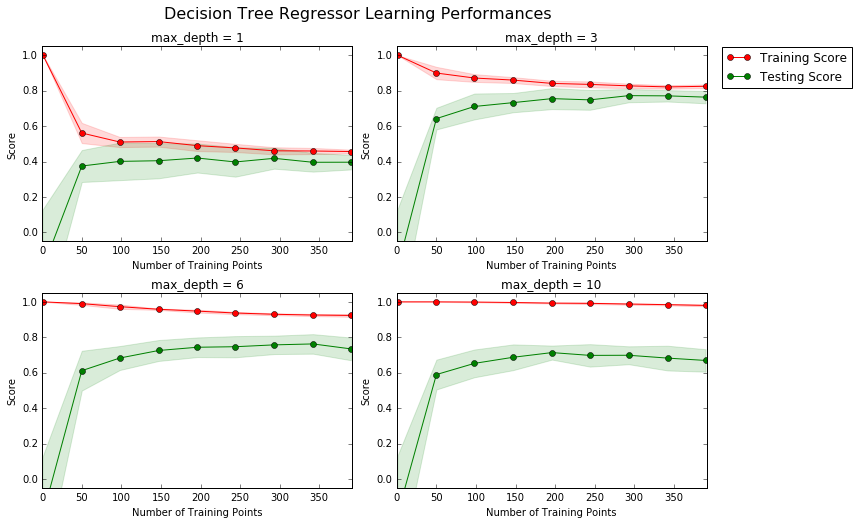

In [155]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

### Question 4 - Learning the Data
*Choose one of the graphs above and state the maximum depth for the model. What happens to the score of the training curve as more training points are added? What about the testing curve? Would having more training points benefit the model?*  
**Hint:** Are the learning curves converging to particular scores?

**Answer: **

*For depth 3, both the Training and the Test curves seems to be converging towards the score of 0.8 as more data is added. After 350 data points, however, the model seems to be quickly running into diminishing returns, and the standard deviation seems to get smaller. So, at this point, adding more data will probably not change the trend.*

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

Run the code cell below and use this graph to answer the following two questions.

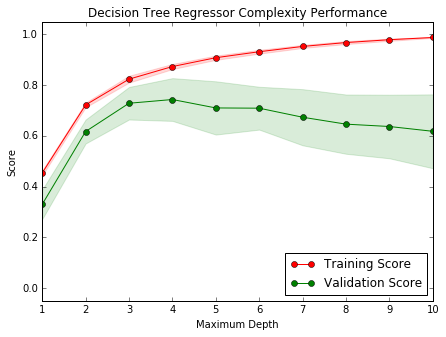

In [156]:
vs.ModelComplexity(X_train, y_train)

### Question 5 - Bias-Variance Tradeoff
*When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? What visual cues in the graph justify your conclusions?*  
**Hint:** How do you know when a model is suffering from high bias or high variance?

**Answer: **

*With Depth 1, the mode has a high Bias. Although the deviation shading is thin, it still has a poor Score (below 0.4) in prediction, so a high Bias is the logical explanation.*

### Question 6 - Best-Guess Optimal Model
*Which maximum depth do you think results in a model that best generalizes to unseen data? What intuition lead you to this answer?*

**Answer: **

*With Depth 10, the deviation becomes pretty high and the model starts to perform poorly with a Score about 0.6. These traits indicate a high Variance problem.*

*The sweet spot for this model appears to be at Depth 3 or 4, where the predictive score is close to 0.8 (the maximum achieved across the Valiadation curve) and the about of Bias and the amount of variance seems to be in a good equilibrium.*

-----

## Evaluating Model Performance
In this final section of the project, you will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

### Question 7 - Grid Search
*What is the grid search technique and how it can be applied to optimize a learning algorithm?*

**Answer: **

*The Grid Search picks up a matrix of parameters and all their possible values, and automatically test the learning algorithm against multiple combinatorials or these values to try to find the best performance without demading a laborious work from the data scientist to try every possible combination himself.*

*So, with Grid Search, we can test a LOT more possible parameter/value pairs and find the one that wields the best result for each learning algorithm we are using (such as SVM).*

### Question 8 - Cross-Validation
*What is the k-fold cross-validation training technique? What benefit does this technique provide for grid search when optimizing a model?*  
**Hint:** Much like the reasoning behind having a testing set, what could go wrong with using grid search without a cross-validated set?

**Answer: **

*The K-Fold Cross-Validation allows us to use all data for both training and testing, by splitting the dataset in multiple chunks and doing both training and testing against them. The algorithm creates a K amount of folds, or chunks of data - let's say, 10 - and loops through these chunks one by one using it as testing sample, while using all the other 9 (k-1) chunks as training samples. Hence, the amount of loops is always also equal to the K number*

*Once the loop is complete, the algorithm picks up the K (10) results and average them out for a final result valid for the entire dataset (although, by default, the sklearn function does not average them out and keeps the results in a K-length array).*

*When a Grid Search is combined with a K-Fold CV loop, we can test many different parameter/value setups, across several partitions in our data, in order to find the best possible parametric result to predict our data.*



### Implementation: Fitting a Model
Your final implementation requires that you bring everything together and train a model using the **decision tree algorithm**. To ensure that you are producing an optimized model, you will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction. Decision trees are part of a class of algorithms called *supervised learning algorithms*.

In addition, you will find your implementation is using `ShuffleSplit()` for an alternative form of cross-validation (see the `'cv_sets'` variable). While it is not the K-Fold cross-validation technique you describe in **Question 8**, this type of cross-validation technique is just as useful!. The `ShuffleSplit()` implementation below will create 10 (`'n_splits'`) shuffled sets, and for each shuffle, 20% (`'test_size'`) of the data will be used as the *validation set*. While you're working on your implementation, think about the contrasts and similarities it has to the K-fold cross-validation technique.

Please note that ShuffleSplit has different parameters in scikit-learn versions 0.17 and 0.18.
For the `fit_model` function in the code cell below, you will need to implement the following:
- Use [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) from `sklearn.tree` to create a decision tree regressor object.
  - Assign this object to the `'regressor'` variable.
- Create a dictionary for `'max_depth'` with the values from 1 to 10, and assign this to the `'params'` variable.
- Use [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) from `sklearn.metrics` to create a scoring function object.
  - Pass the `performance_metric` function as a parameter to the object.
  - Assign this scoring function to the `'scoring_fnc'` variable.
- Use [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) from `sklearn.grid_search` to create a grid search object.
  - Pass the variables `'regressor'`, `'params'`, `'scoring_fnc'`, and `'cv_sets'` as parameters to the object. 
  - Assign the `GridSearchCV` object to the `'grid'` variable.

In [157]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_splits = 10, test_size = 0.20, random_state = 0)

    regressor = DecisionTreeRegressor(random_state=0)
    params = {'max_depth': range(1,11)}
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_



### Making Predictions
Once a model has been trained on a given set of data, it can now be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**. You can use these predictions to gain information about data where the value of the target variable is unknown — such as data the model was not trained on.

### Question 9 - Optimal Model
_What maximum depth does the optimal model have? How does this result compare to your guess in **Question 6**?_  

Run the code block below to fit the decision tree regressor to the training data and produce an optimal model.

In [158]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 4 for the optimal model.


**Answer: **

*Depth of 4.*

*The calculated result is very much in line to the intuitive answer at Question 6. It looked like the best "sweet spot" was Depth of 3 or 4, and indeed 4 is the one.*

### Question 10 - Predicting Selling Prices
Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |
*What price would you recommend each client sell his/her home at? Do these prices seem reasonable given the values for the respective features?*  
**Hint:** Use the statistics you calculated in the **Data Exploration** section to help justify your response.  

Run the code block below to have your optimized model make predictions for each client's home.

Predicted selling price for Client 1's home: $410,400.00
Predicted selling price for Client 2's home: $225,795.65
Predicted selling price for Client 3's home: $963,550.00

Graphs for a visual evaluation of the prices predicted for each house: 


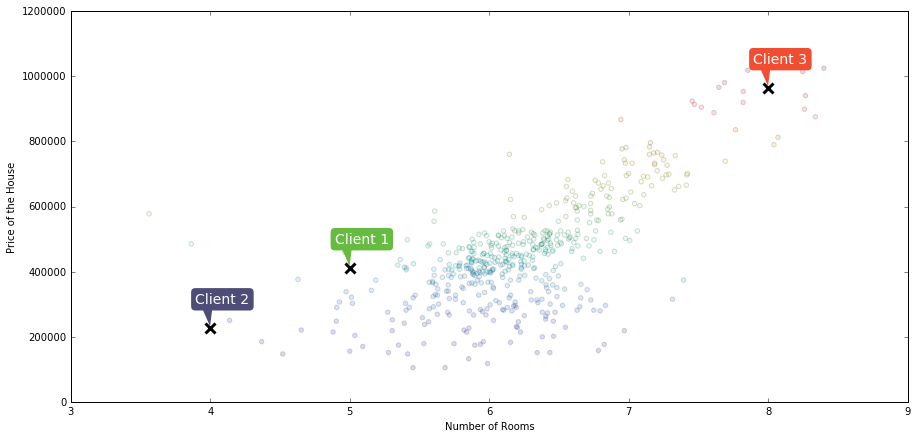

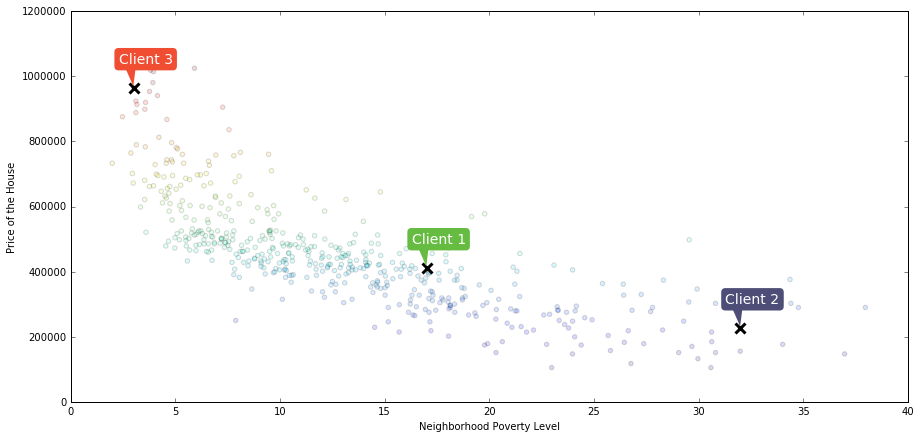

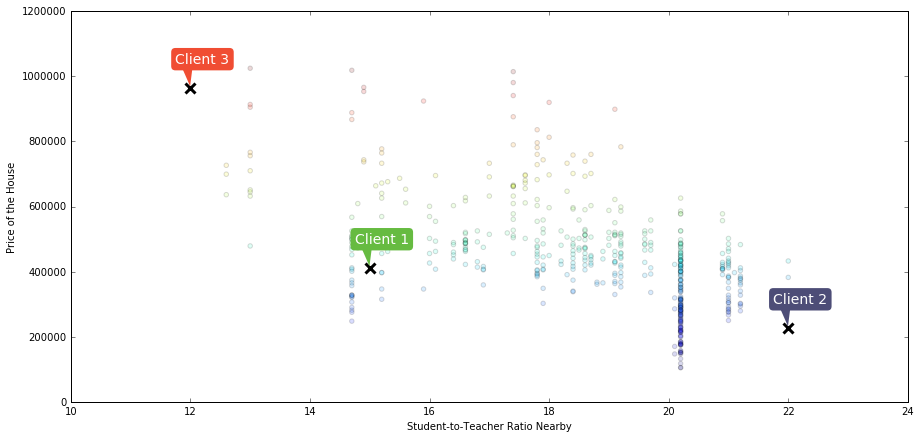

In [159]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
pred = reg.predict(client_data)
for i, price in enumerate(pred):
    print "Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price)
    
    
# Showing graphics to assess the reasons behind each price calculation
from matplotlib.patches import Ellipse
el = Ellipse((2, -1), 0.5, 0.5)

print("")
print("Graphs for a visual evaluation of the prices predicted for each house: ")
client_data_transposed = np.transpose(client_data)

for i, feat in enumerate([['RM', 'Number of Rooms'], ['LSTAT', 'Neighborhood Poverty Level'], ['PTRATIO', 'Student-to-Teacher Ratio Nearby']]):
    plt.figure(figsize=(15,7))
    plt.scatter(features[feat[0]], prices, alpha=0.15, c=prices)
    plt.scatter(client_data_transposed[i], pred, color='black', marker='x', s=100, linewidths=3)        
    plt.xlabel(feat[1])
    plt.ylabel('Price of the House')
    #adding labels to identify the Clients in the graph
    for j, p in enumerate(client_data):
        label_color = (max(0.3,pred[j]/np.max(prices)), max(0.3,1-(abs(pred[j]-np.mean(prices))/np.std(prices))), max(0.2,np.min(prices)/pred[j]))
        plt.annotate('Client ' + str(j+1), 
                     xy=(p[i], pred[j]), 
                     xycoords='data',
                     xytext=(-15, 25), 
                     textcoords='offset points', 
                     size=14,
                     color='white',
                     bbox=dict(boxstyle="round", fc=label_color, ec="none"),
                     arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=label_color, 
                                      ec="none",
                                      patchA=None,
                                      patchB=el,
                                      relpos=(0.2, 0.5),
                                      )
                    )
    plt.draw()

plt.show()    

**Answer: **

*By looking into the feature plots above, we can see how well our predictions fall into the overall patterns of the distributions of real houses.*

*On Client 1's house, predicted at $353,550.00, it has an above-the-average pricing considering only 5 rooms, since most of houses at the same price range gravitate near the 6 Rooms threshold. It's also slightly above in pricing to houses considering other options in the districts of the same Poverty ratio. But in the Student-to-Teacher ratio, it seems to follow the central tendency of houses near the same ratio, if not a bit below it.*

*On Client 2's house, predicted at $225,795.65, the prediction looks compatible with the fact that the house is in the very bottom of all criteria when compared to the main population. Although in the number of Rooms the algorithm didn't have that many samples at 4 units to be trained with, it would not be surprising if lots of 4-Rooms would aglomerate around the price tag of 200k, given the general tendency in the first graph. As for Poverty level and Student-to-Teacher ratio, the house seems to follow the overall tendency.*

*Finally, on Client 3's house, predicted at $963,550.00, the combination of several Rooms, low Poverty and great Student-to-Teacher ratio makes it a clear outlier in the top end of all features. The price is set in a way that the spot of this house given would justly sit on the top of the trend curves of the agglomerates in each of the feature plots. *

### Sensitivity
An optimal model is not necessarily a robust model. Sometimes, a model is either too complex or too simple to sufficiently generalize to new data. Sometimes, a model could use a learning algorithm that is not appropriate for the structure of the data given. Other times, the data itself could be too noisy or contain too few samples to allow a model to adequately capture the target variable — i.e., the model is underfitted. Run the code cell below to run the `fit_model` function ten times with different training and testing sets to see how the prediction for a specific client changes with the data it's trained on.

In [160]:
vs.PredictTrials(features, prices, fit_model, client_data)

print('')
p = [391183.33,424935,415800,420622.22,418377.27,411931.58,399663.16,407232,351577.61,413700]
print('Mean of Trials: ${:,.2f}'.format(np.mean(p)))
print('% of Range over Mean: {0:.2f}%'.format(100 *(np.max(p)-np.min(p))/np.mean(p)))
print('')
print('Standard Deviation of Trials: ${:,.2f}'.format(np.std(p)))
print('% of Standard Deviation from the Mean: {0:.2f}%'.format(100 * np.std(p)/np.mean(p)))

Trial 1: $391,183.33
Trial 2: $424,935.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $73,357.39

Mean of Trials: $405,502.22
% of Range over Mean: 18.09%

Standard Deviation of Trials: $20,338.58
% of Standard Deviation from the Mean: 5.02%


### Question 11 - Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

**Answer: **

*No. *

*If it was just for price, we could apply historical local inflation, but the underlaying conditions behind price differences might contain really big variations. Almost 40 years of difference should likely contain significant changes in parameters such as Net Worth of the neighboorhood and Students-per-Teacher.*

*Also, the amount of information in the housing.csv doesn't seem to be enough to correctly describe all the dimensions involved in house price evaluation. Although the original unfiltered might have contained more parameters, and even if the preditions of the model seem to have been in line to the trends in the dataset, it remains to be seen if with the appropriate amount of parameters as used by real-state agents in the real market, the model would still behave consistently.*

*Finally, on the topic of Robustness, a variation of $73k across different trials seems rather high given its 18% of the mean value of these trials. In the real market, this could mean a loss of up to 18% of revenue on the sale value of the house, which is a huge deal. However, one standard deviation is 5% of the mean, which doesn't too bad but is still high considering a confidence of 95% will imply a variation of + ou - 10% on the sales price. Given these two factors, I would say the model is not robust enough for a real-world application, but it seems it has room for improvement if extra features add more dimensions on the algorithm.*

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.